# EXPLORATORY DATA ANALYSIS (EDA)
### SENSOR + NETWORK + ACCURACY ANALYSIS

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.stats import zscore

# Load dataset
df = pd.read_csv("Datasets/Cleaned_Dataset.csv", dtype={"timestamp": str})
df['timestamp'] = pd.to_datetime(df['timestamp'])

sensor_cols = ["lidar_points", "radar_objects", "camera_objects"]
network_cols = ["packet_drop_rate", "packet_delivery_ratio", "latency_ms", "throughput_kbps"]
accuracy_cols = ["obstacle_detection_accuracy", "decision_accuracy"]
gps_cols = ["gps_latitude", "gps_longitude"]

numeric_cols = gps_cols + sensor_cols + network_cols + accuracy_cols
df_numeric = df[numeric_cols]

________________________________________
### 1. Summary Statistics

In [2]:
df_numeric.describe()

,gps_latitude,gps_longitude,lidar_points,radar_objects,camera_objects,packet_drop_rate,packet_delivery_ratio,latency_ms,throughput_kbps,obstacle_detection_accuracy,decision_accuracy
count,2300.000000,2300.000000,2300.000000,2300.000000,2300.000000,2300.000000,2300.000000,2300.000000,2300.000000,2300.000000,2300.000000
mean,37.499000,-121.505809,19983.899130,27.277391,26.789130,0.150195,0.850363,156.076087,549.044348,0.846967,0.849623
std,0.289869,0.294706,5780.863289,12.779745,12.875871,0.085087,0.086613,82.755323,263.700168,0.086724,0.088263
min,37.000115,-121.999854,10002.000000,5.000000,5.000000,0.000000,0.700000,10.000000,100.000000,0.700000,0.700000
25%,37.243931,-121.754191,14929.000000,16.000000,16.000000,0.076000,0.776000,87.000000,318.000000,0.770000,0.770000
50%,37.499082,-121.512347,19942.000000,27.000000,26.500000,0.153000,0.852000,158.000000,546.500000,0.850000,0.850000
75%,37.751229,-121.244705,25039.250000,38.000000,38.000000,0.221000,0.928000,225.000000,782.000000,0.920000,0.930000
max,37.999677,-121.001123,29983.000000,49.000000,49.000000,0.300000,1.000000,299.000000,999.000000,1.000000,1.000000


_________________________________________
### 2. Sensor Behaviour Analysis

Pairplot

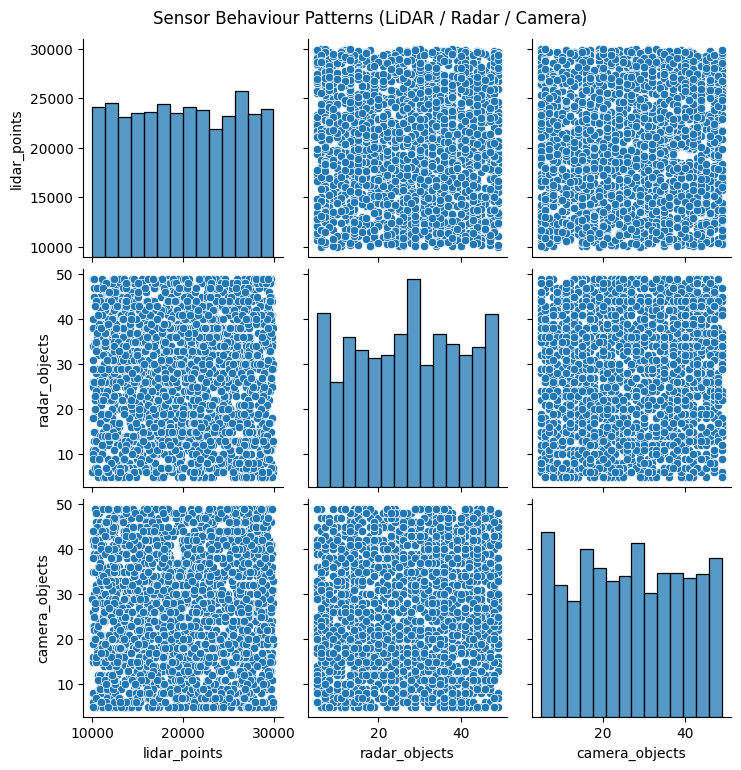

In [3]:
sns.pairplot(df[sensor_cols])
plt.suptitle("Sensor Behaviour Patterns (LiDAR / Radar / Camera)", y=1.02)
plt.show()

Boxplot

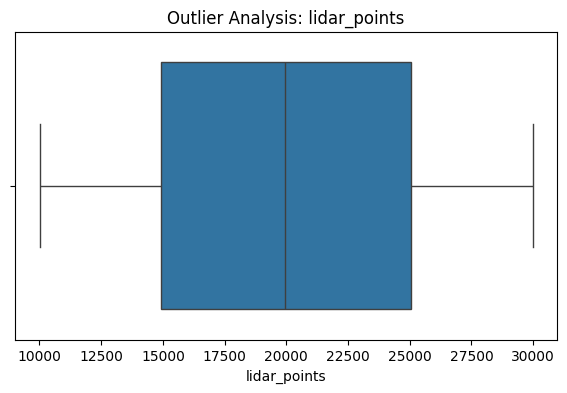

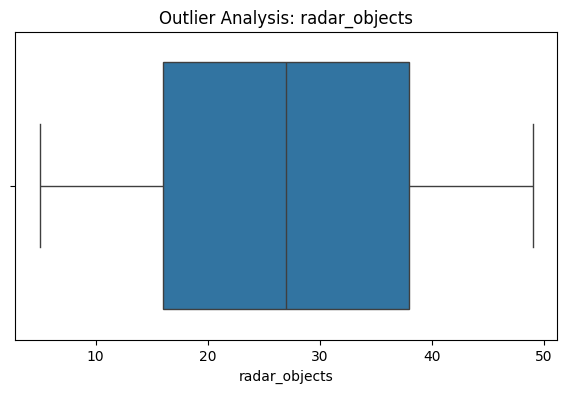

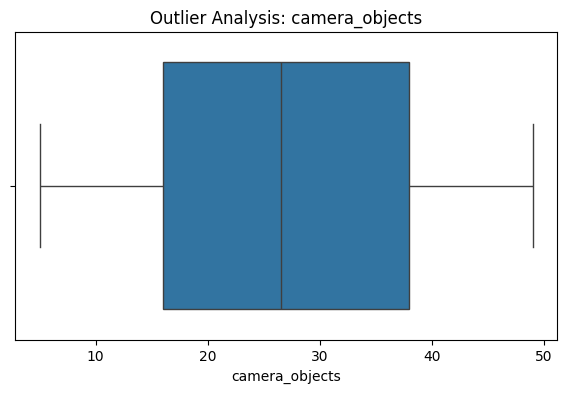

In [4]:
for col in sensor_cols:
    plt.figure(figsize=(7,4))
    sns.boxplot(x=df[col])
    plt.title(f"Outlier Analysis: {col}")
    plt.show()

______________________________________________
### 3. Network Performance Analysis

Network Histogram

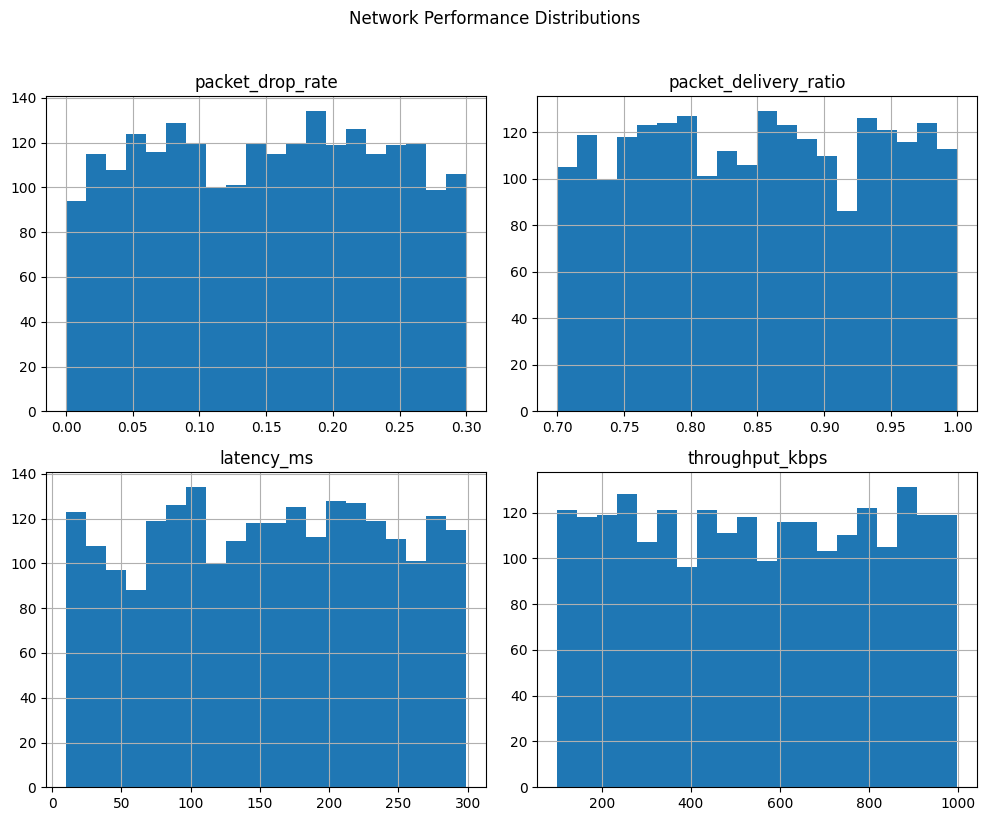

In [5]:
df[network_cols].hist(figsize=(10, 8), bins=20)
plt.suptitle("Network Performance Distributions", y=1.02)
plt.tight_layout()
plt.show()

Network Outliers

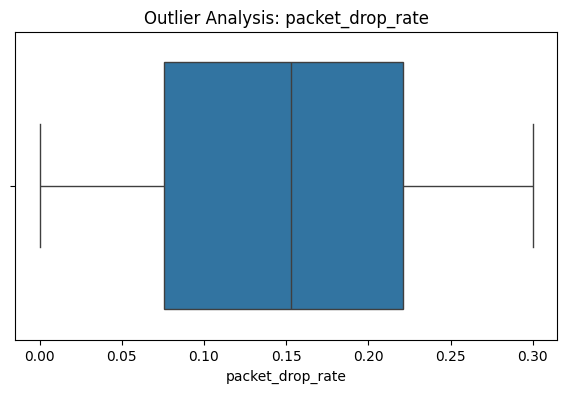

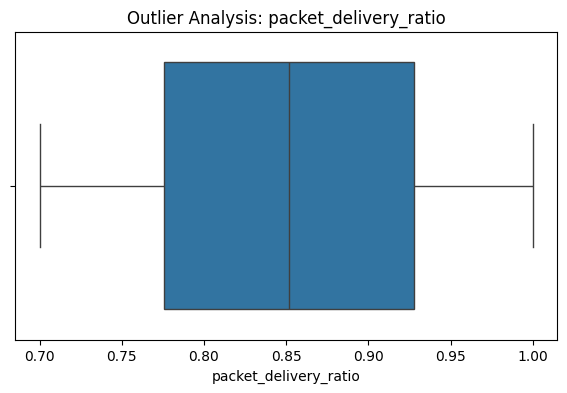

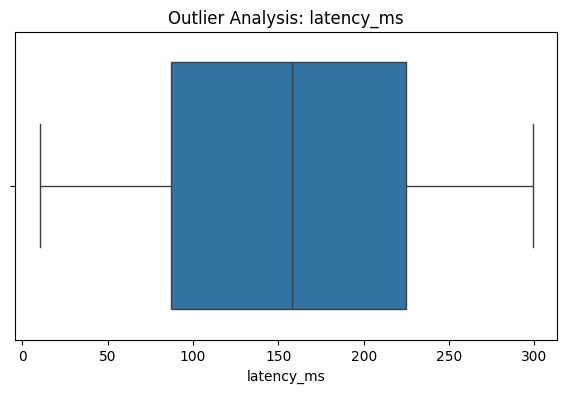

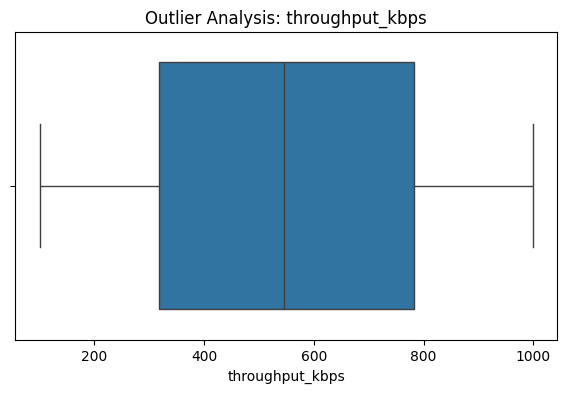

In [6]:
for col in network_cols:
    plt.figure(figsize=(7,4))
    sns.boxplot(x=df[col])
    plt.title(f"Outlier Analysis: {col}")
    plt.show()

_________________
### 4. Accuracy Metric Analysis

Accuracy Histogram

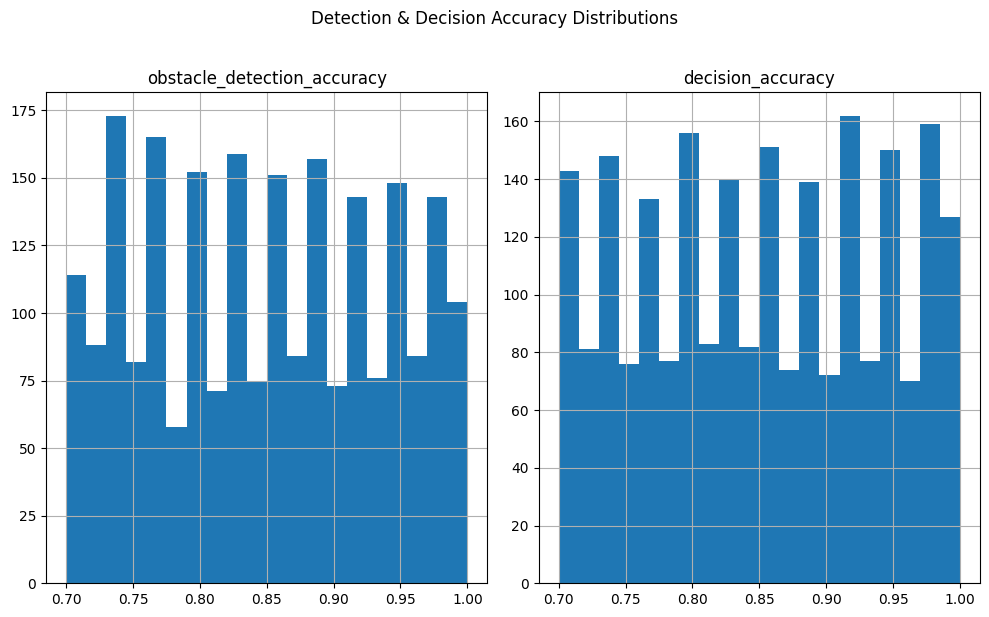

In [7]:
df[accuracy_cols].hist(figsize=(10, 6), bins=20)
plt.suptitle("Detection & Decision Accuracy Distributions", y=1.02)
plt.tight_layout()
plt.show()

Accuracy Relationship

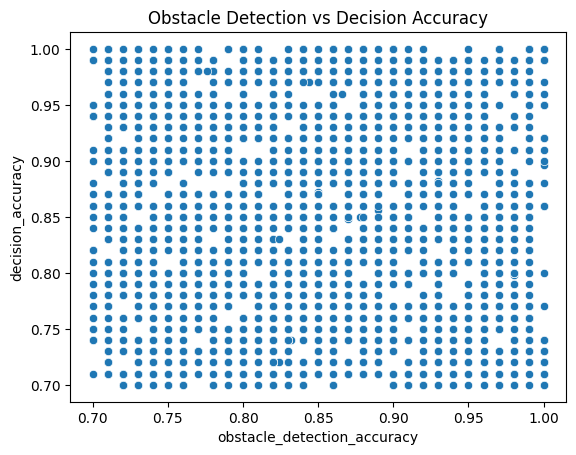

In [8]:
sns.scatterplot(data=df, x="obstacle_detection_accuracy", y="decision_accuracy")
plt.title("Obstacle Detection vs Decision Accuracy")
plt.show()

___________________________________________________
### 5. GPS Position Analysis

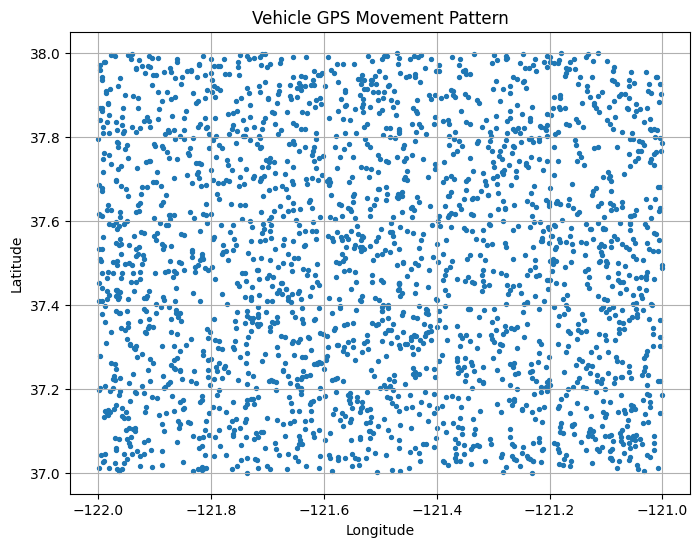

In [9]:
plt.figure(figsize=(8,6))
plt.scatter(df["gps_longitude"], df["gps_latitude"], s=8)
plt.title("Vehicle GPS Movement Pattern")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()

_____________________________________________
### 6. NON-LINEAR RELATIONSHIPS (Bin Analysis)

Even when correlations are near zero, non-linear effects exist.

Latency impact on decision accuracy

C:\Users\rashi\AppData\Local\Temp\ipykernel_9960\167749198.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  latency_vs_accuracy = df.groupby("latency_bin")["decision_accuracy"].mean()


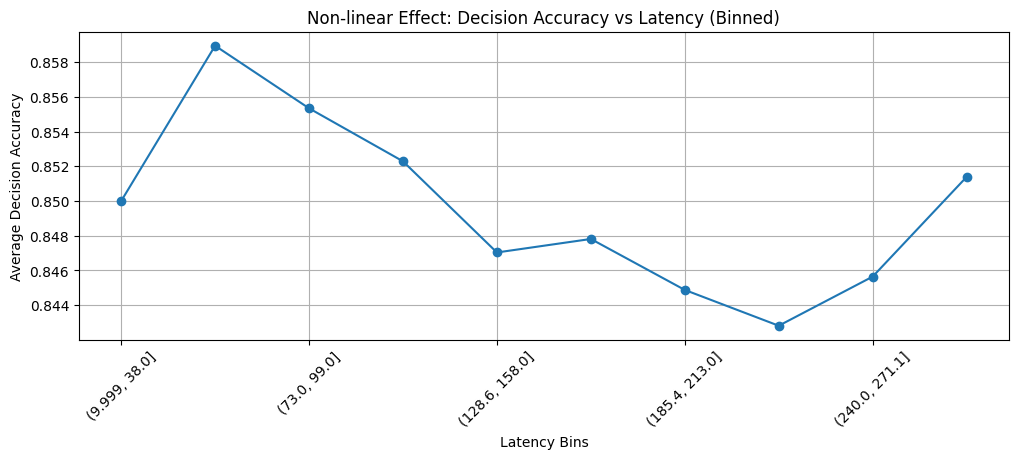

In [10]:
df["latency_bin"] = pd.qcut(df["latency_ms"], 10)

latency_vs_accuracy = df.groupby("latency_bin")["decision_accuracy"].mean()

plt.figure(figsize=(12,4))
latency_vs_accuracy.plot(marker='o')
plt.xticks(rotation=45)
plt.title("Non-linear Effect: Decision Accuracy vs Latency (Binned)")
plt.ylabel("Average Decision Accuracy")
plt.xlabel("Latency Bins")
plt.grid(True)
plt.show()

Packet Drop Effect

C:\Users\rashi\AppData\Local\Temp\ipykernel_9960\3236241979.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  drop_vs_accuracy = df.groupby("drop_bin")["decision_accuracy"].mean()


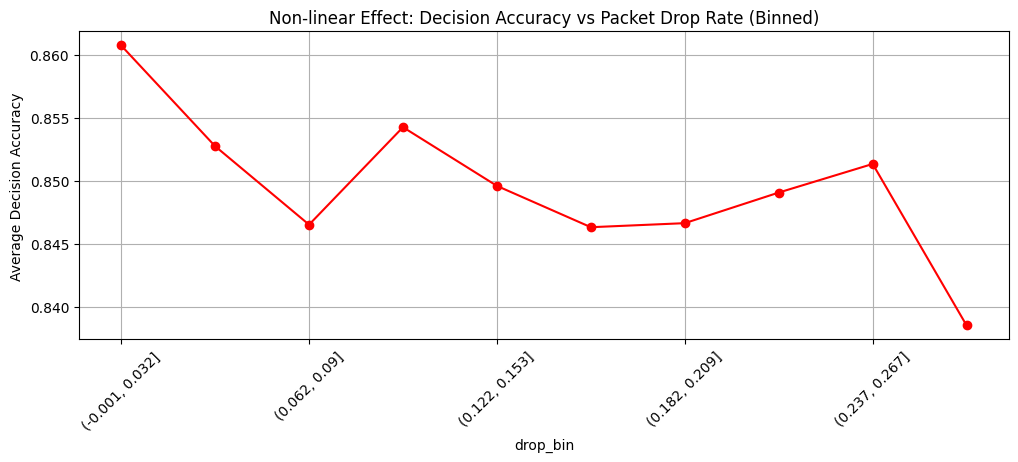

In [11]:
df["drop_bin"] = pd.qcut(df["packet_drop_rate"], 10)

drop_vs_accuracy = df.groupby("drop_bin")["decision_accuracy"].mean()

plt.figure(figsize=(12,4))
drop_vs_accuracy.plot(marker='o', color='red')
plt.xticks(rotation=45)
plt.title("Non-linear Effect: Decision Accuracy vs Packet Drop Rate (Binned)")
plt.ylabel("Average Decision Accuracy")
plt.grid(True)
plt.show()

### 7. K-MEANS CLUSTERING (BEST FOR MULTI-MODAL DATA)

Clustering real VANET states:

Sensor-heavy

Network-heavy

Low accuracy periods

Normal driving

In [12]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_numeric)
kmeans = KMeans(n_clusters=4, random_state=42, n_init='auto')
df["cluster"] = kmeans.fit_predict(scaled_data)

PCA Plot

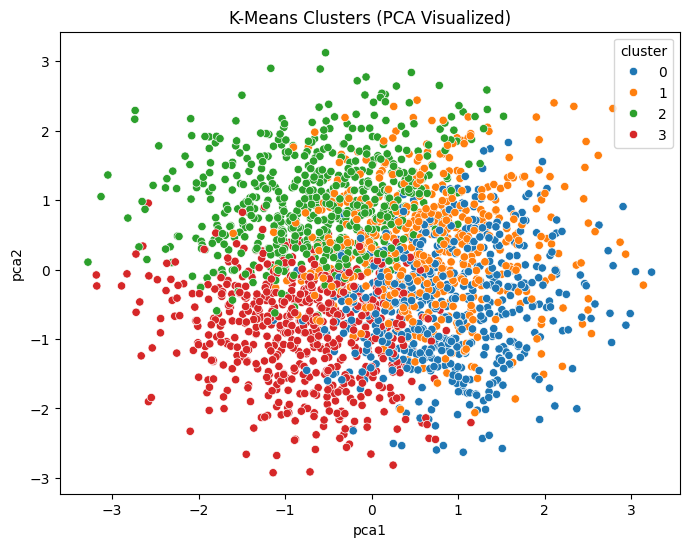

In [13]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)

df["pca1"] = pca_result[:,0]
df["pca2"] = pca_result[:,1]

plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x="pca1", y="pca2", hue="cluster", palette="tab10")
plt.title("K-Means Clusters (PCA Visualized)")
plt.show()

Cluster Insights

In [14]:
cluster_summary = df.groupby("cluster")[numeric_cols].mean()
display(cluster_summary)

,gps_latitude,gps_longitude,lidar_points,radar_objects,camera_objects,packet_drop_rate,packet_delivery_ratio,latency_ms,throughput_kbps,obstacle_detection_accuracy,decision_accuracy
cluster,,,,,,,,,,,
0,37.408612,-121.396867,20081.021898,26.262774,18.317518,0.134854,0.807456,178.784672,577.067518,0.819865,0.918394
1,37.566522,-121.583872,17693.541284,23.866055,23.629358,0.150192,0.819218,208.477064,587.240367,0.851134,0.773083
2,37.624059,-121.464696,22557.580750,32.508972,29.898858,0.222325,0.868083,127.303426,522.541599,0.863181,0.840979
3,37.391376,-121.577117,19339.715488,25.944444,34.294613,0.089915,0.900236,116.740741,515.496633,0.851414,0.865323


Cluster Size Distribution

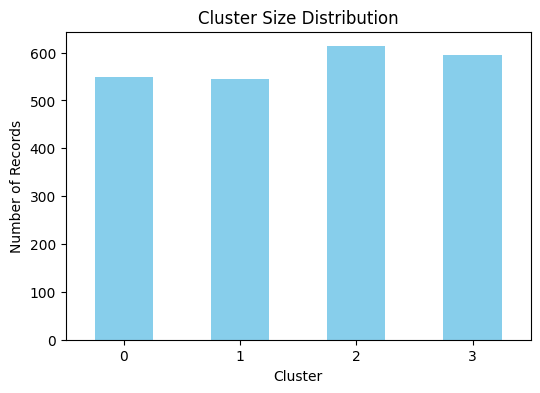

In [15]:
plt.figure(figsize=(6,4))
df["cluster"].value_counts().sort_index().plot(kind="bar", color="skyblue")
plt.title("Cluster Size Distribution")
plt.xlabel("Cluster")
plt.ylabel("Number of Records")
plt.xticks(rotation=0)
plt.show()


Cluster Feature Radar Chart

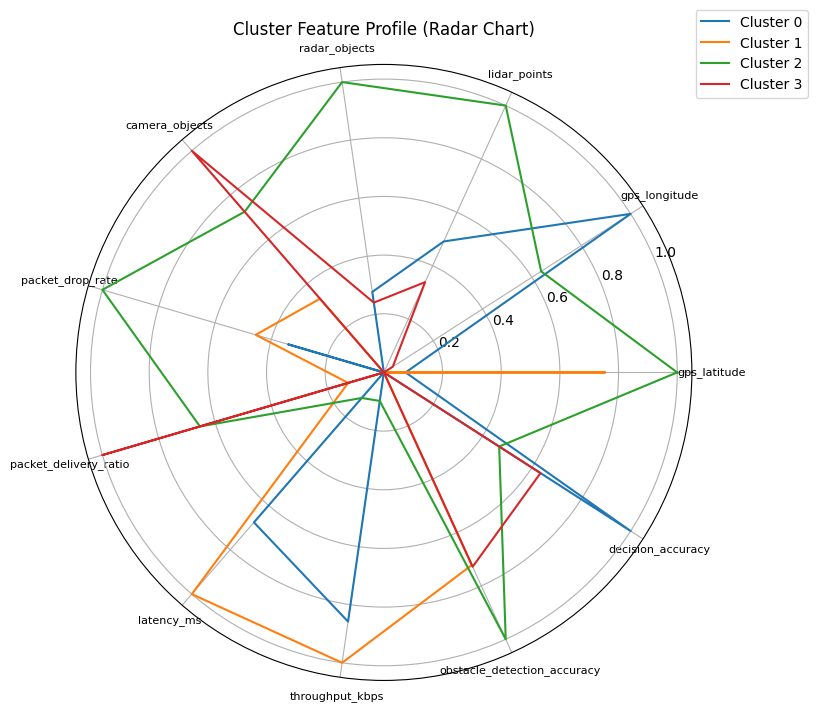

In [16]:
from math import pi

cluster_means = cluster_summary.copy()

# Normalize 0–1 for plotting
cluster_norm = (cluster_means - cluster_means.min()) / (cluster_means.max() - cluster_means.min())

features = cluster_norm.columns.tolist()

plt.figure(figsize=(8,8))

for i in cluster_norm.index:
    angles = [n / float(len(features)) * 2 * pi for n in range(len(features))]
    angles += angles[:1]
    
    values = cluster_norm.loc[i].tolist()
    values += values[:1]
    
    plt.polar(angles, values, label=f"Cluster {i}")

plt.xticks(angles[:-1], features, fontsize=8)
plt.title("Cluster Feature Profile (Radar Chart)", size=12)
plt.legend(loc="upper right", bbox_to_anchor=(1.2, 1.1))
plt.show()
